<a href="https://colab.research.google.com/github/shubin023/generative_ai/blob/main/seminar2_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Deep Generative Models</center>
## <center>Seminar 2</center>

<center>27.02.2025</center>


## Plan

- Flows Recap
- Planar and Radial Flows
- Forward vs Reverse KL

What do you remember about Normalizing flows?

<center>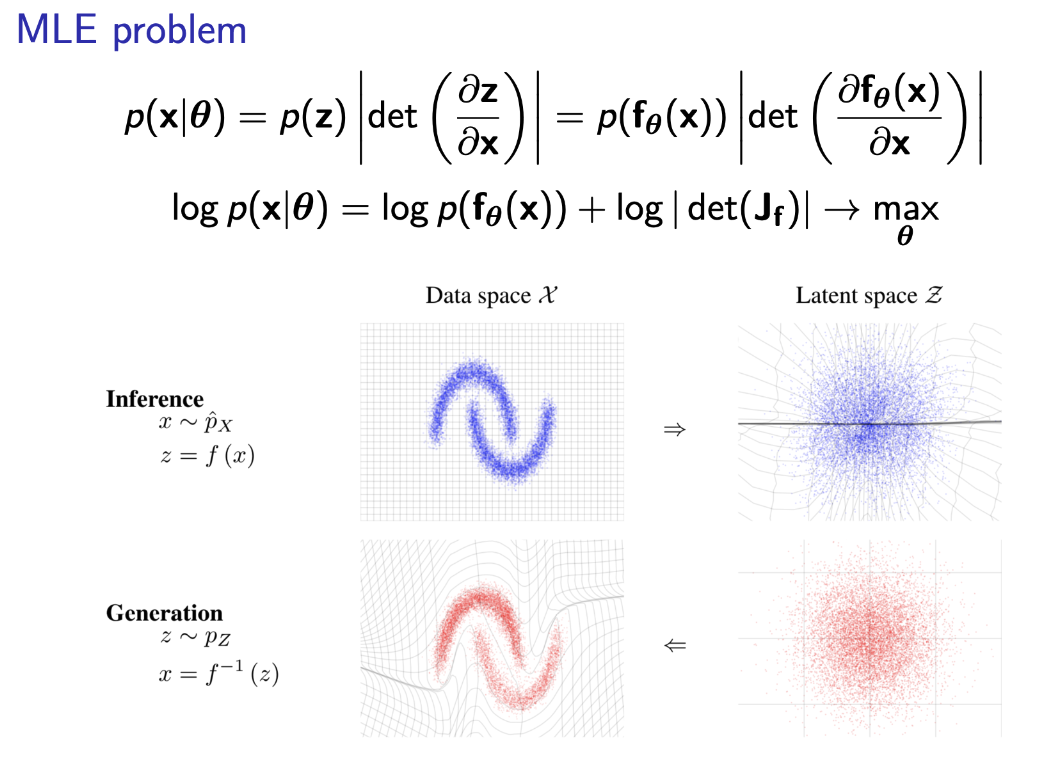</center>

<center>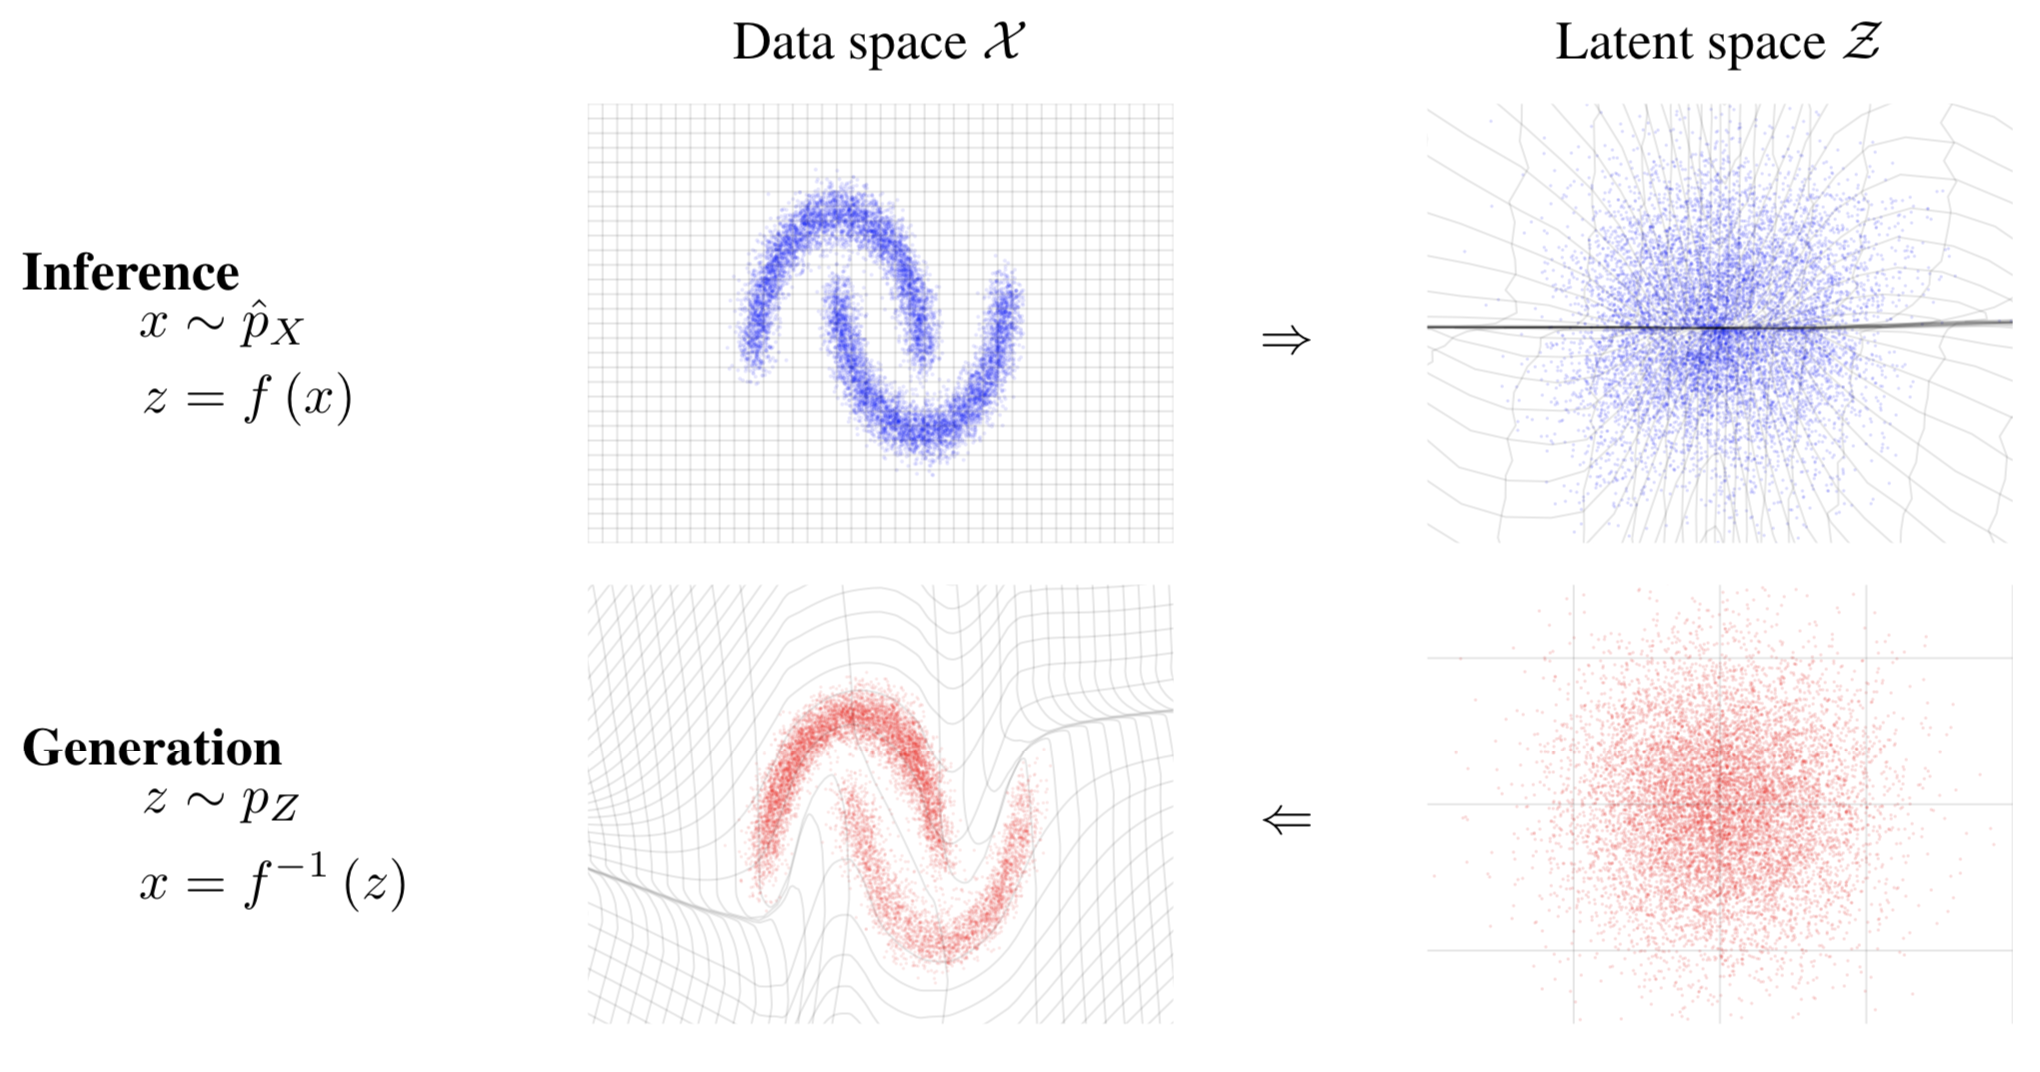</center>

We need:
1. Invertable mapping
2. Same dim
3. Fast $\det J$ calculation

## Planar Flow


$g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$


Where:
- $\theta = \{\mathbf{u}, \mathbf{w} \in \mathbb{R}^d, b \in \mathbb{R}\}$ are parameters
- $h$ is a nonlinearity (typically $\tanh$)

### Jacobian Determinant
$\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}} = \mathbf{I} + \mathbf{u}h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T$

$\det \left|\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}}\right| =
\left(1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{I}^{-1}\mathbf{u} \right) \det(\mathbf{I}) =
1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T \mathbf{u}$

$\det \left|\dfrac{\partial g(\mathbf{z}, \theta)}{\partial \mathbf{z}}\right| = \left(1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{u} \right)$

- Determinant computation: $O(d)$ instead of $O(d^3)$

Let $h(x) = \tanh(x)$. When $g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$ is reversible?



### Invertibility Condition
For $h(x) = \tanh(x)$, the transformation is invertible when:

$\mathbf{w}^T\mathbf{u} \geq -1$

**Important note:** We don't know the explicit inverse function, but mathematical theory only requires that it exists.

### Proof of Planar Flow Invertibility Condition

1. For invertibility, the determinant of the Jacobian must be non-zero: $\det(\partial g/\partial z) \neq 0$

2. For Planar Flow, this determinant is: $\det(\partial g/\partial z) = 1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{u}$

3. For $h(x) = \tanh(x)$, we have $0 < h'(x) = 1 - \tanh^2(x) \leq 1$

4. To ensure $\det(\partial g/\partial z) \neq 0$, we need: $1 + h'(\mathbf{w}^T\mathbf{z} + b)\mathbf{w}^T\mathbf{u} \neq 0$

5. Since $h' > 0$, the worst case occurs when $h' \approx 1$, so we need $\mathbf{w}^T\mathbf{u} \geq -1$ to guarantee invertibility across all inputs

## Planar Flow

$g(\mathbf{z}) = \mathbf{z} + \mathbf{u}h(\mathbf{w}^T\mathbf{z} + b)$


$\theta = \{\mathbf{u,w} \in \mathbb{R}^d, b \in \mathbb{R}\}$

$\mathbf{w}^T\mathbf{u} \geq -1$

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as LA

w = np.array([5., 0])
u = np.array([1., 0])
b = 0

def h(x):
    return np.tanh(x)

def g(z, w=w, u=u, b=b):
    w = np.array(w)
    u = np.array(u)

    assert np.dot(w, u) >= -1
    y = z + np.dot(h(np.dot(z, w) + b).reshape(-1,1), u.reshape(1,-1))
    return y

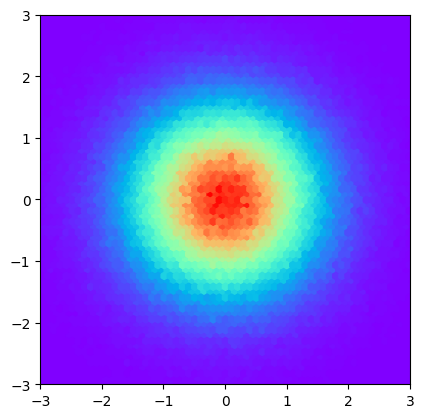

In [ ]:
z = np.random.normal(size=(int(1e6),2))
plt.hexbin(z[:,0], z[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

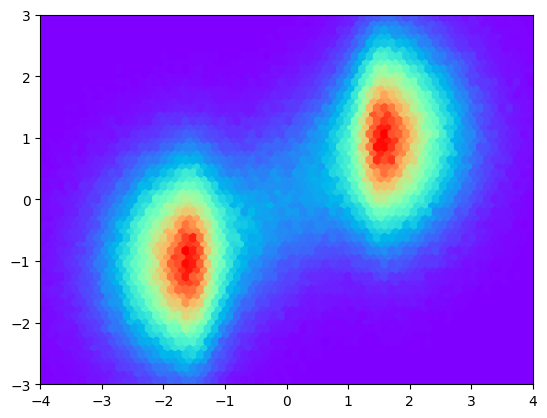

In [ ]:
w = np.array([5., 0])
u = np.array([1, 1])
b = 0

x = g(z, w=w, u=u, b=b)

plt.hexbin(x[:,0], x[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-4, 4])
plt.ylim([-3, 3])
plt.show()

### Radial Flow
$g(\mathbf{z}, \theta) = \mathbf{z} + \beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)$

Where:
- $\theta = \{\alpha \in \mathbb{R}^{+}, \beta \in \mathbb{R}, \mathbf{z}_0 \in \mathbb{R}^{d} \}$
- $r = ||\mathbf{z} - \mathbf{z}_0||$ is the distance to center
- $h(\alpha, r) = \dfrac{1}{\alpha + r}$ is the distance function

$g(\mathbf{z}, \theta) = \mathbf{z} + \beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)$

$\dfrac{\partial g(\mathbf{z})}{\partial \mathbf{z}} =
\mathbf{I} + \beta\left((\mathbf{z}-\mathbf{z}_0)h'(\alpha,r)\frac{\partial r}{\partial \mathbf{z}} + h(\alpha,r)\mathbf{I}\right)
=(1+\beta h(\alpha,r))\mathbf{I} + \beta h'(\alpha,r)(\mathbf{z}-\mathbf{z}_0)\frac{(\mathbf{z}-\mathbf{z}_0)^T}{||\mathbf{z}-\mathbf{z}_0||}$

### Jacobian Determinant
$\dfrac{\partial g(\mathbf{z})}{\partial \mathbf{z}} = (1+\beta h(\alpha,r))\mathbf{I} + \beta h'(\alpha,r)(\mathbf{z}-\mathbf{z}_0)\frac{(\mathbf{z}-\mathbf{z}_0)^T}{||\mathbf{z}-\mathbf{z}_0||}$

$\det\dfrac{\partial g(\mathbf{z})}{\partial \mathbf{z}} = \left(1 + \beta h(\alpha,r) + \beta h'(\alpha,r)r\right)(1+\beta h(\alpha,r))^{d-1}$

**Invertibility condition:** $g(z)$ is reversible when $\beta \geq -\alpha$

## Radial Flow

$g(\mathbf{z}, \theta) = \mathbf{z} + \beta h(\alpha,r)(\mathbf{z}-\mathbf{z}_0)$

$\theta = \{\alpha \in \mathbb{R}^{+}, \beta \in \mathbb{R}, \mathbf{z}_0 \in \mathbb{R}^{d} \}$

$r = ||\mathbf{z} - \mathbf{z}_0||$

$h(\alpha, r) = \dfrac{1}{\alpha + r}$

$\beta \geq -\alpha$

In [ ]:
z0 = np.array([0, 0])
a = 2
b = 5

def h(r,a):
    return 1/(a+r)

def g(z, z0=z0, a=a, b=b):
    assert b >= -a
    z0 = np.array(z0)
    r = LA.norm(z - z0, axis=1).reshape(-1, 1)
    y = z + b * h(r,a) * (z - z0)
    return y

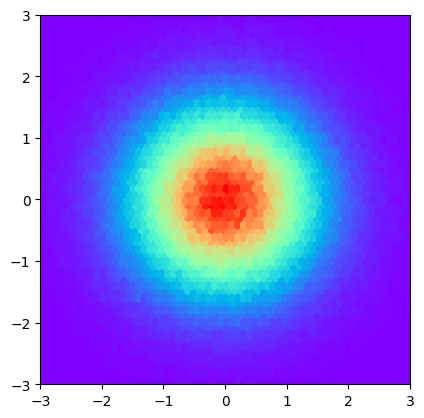

In [ ]:
z = np.random.normal(size=(int(1e6),2))
plt.hexbin(z[:,0], z[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()

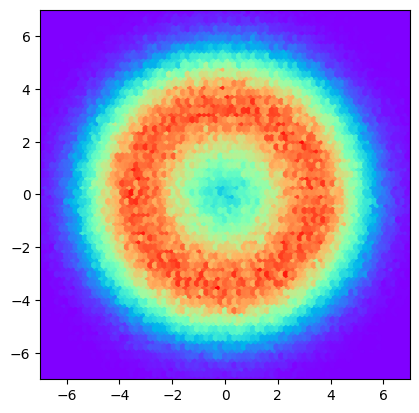

In [ ]:
z0 = np.array([0, 0])
a = 1
b = 5

x = g(z, z0=z0, a=a, b=b)
plt.hexbin(x[:,0], x[:,1], cmap='rainbow')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-7, 7])
plt.ylim([-7, 7])
plt.show()

### Forward vs Reverse KL

### Density Transformation

- $\pi(x)$: Target complex distribution (can sample from)
- $p(z)$: Base simple distribution (can sample and evaluate density)  (typically standard normal distribution $\mathcal{N}(0, I)$)
- $f: X \rightarrow Z$: Forward mapping
- $g: Z \rightarrow X$: Inverse mapping

By change of variables:
$p_x(x) = p_z(f(x))|\det J_f(x)|$

### Forward KL Divergence

$KL[\pi(x), p_x(x|\theta)] = \mathbb{E}_{\pi(x)}\left[\log\frac{\pi(x)}{p_x(x|\theta)}\right]$

$= \mathbb{E}_{\pi(x)}[\log \pi(x)] - \mathbb{E}_{\pi(x)}[\log p_z(f(x)) + \log |\det J_f(x)|]$

Minimizing Forward KL is equivalent to maximizing:
$\mathbb{E}_{\pi(x)}[\log p_z(f(x)) + \log |\det J_f(x)|]$

This is equivalent to Maximum Likelihood Estimation (MLE)

### Problem Formulation for Forward KL Divergence in Normalizing Flows

#### Problem

Consider a probability space $X$ with a target distribution $\pi(x)$ from which we can sample, but cannot directly evaluate the probability density.

#### Objective

Construct a parametric model $p_x(x|\theta)$ that approximates the unknown target distribution $\pi(x)$.

### Approach using Normalizing Flows

1. Define an invertible parametric transformation $f_θ: X → Z$, where $Z$ is a latent variable space
2. Choose a simple base distribution $p(z)$ in the $Z$ space (typically standard normal)
3. Define the induced distribution in the $X$ space:
   $p_x(x|\theta) = p(f_θ(x))|\det J_{f_θ}(x)|$, where $J_{f_θ}$ is the Jacobian of the transformation

#### Optimization Problem with Forward KL

Minimize the Kullback-Leibler divergence between the target distribution and our model:

$$\min_{\theta} KL(\pi(x) \| p_x(x|\theta)) = \min_{\theta} \mathbb{E}_{x \sim \pi(x)}\left[\log \frac{\pi(x)}{p_x(x|\theta)}\right]$$

After transformations, this is equivalent to:

$$\max_{\theta} \mathbb{E}_{x \sim \pi(x)}\left[\log p(f_θ(x)) + \log|\det J_{f_θ}(x)|\right]$$

### Practical Implementation

1. Data Sampling: Obtain a set of samples $\{x_1, x_2, ..., x_N\}$ from the target distribution $\pi(x)$
2. Define the structure of the normalizing flow $f_θ$ (e.g., Planar Flow, Radial Flow)
3. Optimize the parameters $\theta$ by maximizing the empirical estimate of the objective function:
   $$\max_{\theta} \frac{1}{N} \sum_{i=1}^N \left[\log p(f_θ(x_i)) + \log|\det J_{f_θ}(x_i)|\right]$$

### Result

After training, the model enables us to:
- Evaluate probability density at points in the $X$ space
- If the inverse transformation $g_θ = f_θ^{-1}$ is known, we can also generate new samples

### KL Duality Theorem

$\arg\min\limits_{\theta} KL(\pi(x) || p_x(x|\theta)) = \arg\min\limits_{\theta} KL(p_z(z|\theta) || p(z))$

$\arg\min\limits_{\theta} KL(p_x(x|\theta) || \pi(x)) = \arg\min\limits_{\theta} KL(p(z) || p_z(z|\theta))$

**Important Note**:

This duality shows that optimizing flows in either space (original or latent) produces equivalent results.

### First Equality:
1. **Forward KL in x-space**:
   $KL(\pi(x) \| p_x(x|\theta)) = \int \pi(x) \log \frac{\pi(x)}{p_x(x|\theta)} dx$

2. **Relationship between distributions**:
   With $z = f_\theta(x)$: $p_x(x|\theta) = p_z(f_\theta(x)) \cdot |\det J_{f_\theta}(x)|$

3. **Substitute into KL-divergence**:
   $KL(\pi(x) \| p_x(x|\theta)) = \int \pi(x) \log \pi(x) dx - \int \pi(x) \log p_z(f_\theta(x)) dx - \int \pi(x) \log |\det J_{f_\theta}(x)| dx$

4. **Transform to z-space**:
   With $x = g_\theta(z)$: $p_z(z|\theta) = \pi(g_\theta(z)) \cdot |\det J_{g_\theta}(z)|$

5. **Rewrite in z-space and use Jacobian property** $|\det J_{f_\theta}(g_\theta(z))| = |\det J_{g_\theta}(z)|^{-1}$:
   $\int \pi(x) \log p_z(f_\theta(x)) dx = \int p_z(z|\theta) \log p_z(z) dz$
   
   $\int \pi(x) \log |\det J_{f_\theta}(x)| dx = \int p_z(z|\theta) \log |\det J_{g_\theta}(z)|^{-1} dz$

6. **Simplify**:
   $KL(\pi(x) \| p_x(x|\theta)) = \text{constant} + \int p_z(z|\theta) \log \frac{p_z(z|\theta)}{p(z)} dz = \text{constant} + KL(p_z(z|\theta) \| p(z))$

### Second Equality:
1. **Reverse KL in x-space**:
   $KL(p_x(x|\theta) \| \pi(x)) = \int p_x(x|\theta) \log \frac{p_x(x|\theta)}{\pi(x)} dx$

2. **Distribution relationship**:
   With $z = f_\theta(x)$ and $x = g_\theta(z)$: $p_x(x|\theta) = p(z) \cdot |\det J_{g_\theta}(z)|^{-1}|_{z=f_\theta(x)}$

3. **Substitute into KL**:
   $KL(p_x(x|\theta) \| \pi(x)) = \int p_x(x|\theta) \log \frac{p(f_\theta(x)) \cdot |\det J_{g_\theta}(f_\theta(x))|^{-1}}{\pi(x)} dx$

4. **Change variables to z-space**:
   With $dx = |\det J_{g_\theta}(z)| dz$:
   
   $KL(p_x(x|\theta) \| \pi(x)) = \int p(z) \log \frac{p(z)}{\pi(g_\theta(z)) \cdot |\det J_{g_\theta}(z)|} dz$

5. **Identify transformed density**:
   $p_z(z|\theta) = \pi(g_\theta(z)) \cdot |\det J_{g_\theta}(z)|$

6. **Final form**:
   $KL(p_x(x|\theta) \| \pi(x)) = \int p(z) \log \frac{p(z)}{p_z(z|\theta)} dz = KL(p(z) \| p_z(z|\theta))$

### Reverse KL Divergence

$KL[p_x(x|\theta), \pi(x)] = \mathbb{E}_{p_x(x|\theta)}\left[\log\frac{p_x(x|\theta)}{\pi(x)}\right]$

Using variable substitution and LOTUS theorem:
$KL[p_x(x|\theta), \pi(x)] = \mathbb{E}_{p(z)}[\log p_z(z) - \log |\det J_g(z)| - \log \pi(g(z))]$

Minimizing Reverse KL is equivalent to maximizing:
$\mathbb{E}_{p(z)}[\log |\det J_g(z)| + \log \pi(g(z))]$

### Problem Formulation for Reverse KL Divergence in Normalizing Flows

#### Problem

Consider a probability space $X$ with a target distribution $\pi(x)$ whose probability density function can be evaluated (possibly up to a normalization constant) but sampling from it directly is difficult or impossible.

#### Objective

Construct a parametric model $p_x(x|\theta)$ that approximates the target distribution $\pi(x)$ and allows for efficient sampling.

### Approach using Normalizing Flows

1. Define an invertible parametric transformation $g_θ: Z → X$, where $Z$ is a latent variable space
2. Choose a simple base distribution $p(z)$ in the $Z$ space (typically standard normal) that is easy to sample from
3. Define the induced distribution in the $X$ space:
   $p_x(x|\theta) = p(f_θ(x))|\det J_{f_θ}(x)|$, where $f_θ = g_θ^{-1}$ and $J_{f_θ}$ is the Jacobian of $f_θ$

### Optimization Problem with Reverse KL

Minimize the reverse Kullback-Leibler divergence between our model and the target distribution:

$$\min_{\theta} KL(p_x(x|\theta) \| \pi(x)) = \min_{\theta} \mathbb{E}_{x \sim p_x(x|\theta)}\left[\log \frac{p_x(x|\theta)}{\pi(x)}\right]$$

Using the change of variables and the duality theorem, this is equivalent to:

$$\min_{\theta} KL(p(z) \| p_z(z|\theta)) = \min_{\theta} \mathbb{E}_{z \sim p(z)}\left[\log \frac{p(z)}{p_z(z|\theta)}\right]$$

Which simplifies to:

$$\max_{\theta} \mathbb{E}_{z \sim p(z)}\left[\log \pi(g_θ(z)) + \log|\det J_{g_θ}(z)|\right]$$

### Practical Implementation

1. Sampling from Base Distribution: Generate samples $\{z_1, z_2, ..., z_N\}$ from the base distribution $p(z)$
2. Define the structure of the normalizing flow $g_θ$ (e.g., Planar Flow, Radial Flow)
3. Optimize the parameters $\theta$ by maximizing the empirical estimate of the objective function:
   $$\max_{\theta} \frac{1}{N} \sum_{i=1}^N \left[\log \pi(g_θ(z_i)) + \log|\det J_{g_θ}(z_i)|\right]$$

### Interpretation

Unlike Forward KL, this approach:
- Does not require sampling from the target distribution $\pi(x)$
- Allows for efficient sampling after training (by sampling $z$ and applying $g_θ$)
- Requires density evaluation of $\pi(x)$ (at least up to a normalization constant)
- Is not equivalent to maximum likelihood estimation

### Result

After training, the model enables us to:
- Generate samples from an approximation to $\pi(x)$ by sampling $z \sim p(z)$ and computing $x = g_θ(z)$

### Recap

| Flow Type | What You Know About $\pi(x)$ | Problem You Want to Solve | KL-Divergence Used | Flow Direction | Training Objective |
|-----------|------------------------------|---------------------------|-------------------|---------------|-------------------|
| Forward KL in X-space | Samples $X_1, \dots, X_N$ | PDF estimation $\pi(x)$ | $\text{Forward }KL(\pi(x) \parallel p_{x}(x \mid \theta))$ | $f_{\theta}: X \rightarrow Z$ | $-\mathbb{E}_{\pi(x)} \left[\log p_z(f(x, \theta)) + \log \mid \det J_f \mid\right]$ |
| Reverse KL in X-space | Unnormalized PDF $\hat{\pi}(x)$ | Sample from $\pi(x)$ | $\text{Reverse }KL(p_{x}(x \mid \theta) \parallel \pi(x))$ | $g_{\theta}: Z \rightarrow X$ | $-\mathbb{E}_{p(z)} \left[\log \mid \det J_g \mid + \log \pi(g(z, \theta))\right]$ |
| Reverse KL in Z-space | Samples $X_1, \dots, X_N$ | PDF estimation $\pi(x)$ | $\text{Reverse }KL(p_z(z\mid\theta) \parallel p(z))$ | $f_{\theta}: X \rightarrow Z$ | $-\mathbb{E}_{\pi(x)} \left[\log \mid \det J_f \mid + \log p_z(f(x, \theta))\right]$ |
| Forward KL in Z-space | Unnormalized PDF $\hat{\pi}(x)$ | Sample from $\pi(x)$ | $\text{Forward }KL(p(z) \parallel p_{z}(z\mid\theta))$ | $g_{\theta}: Z \rightarrow X$ | $-\mathbb{E}_{p_z(z)} \left[\log \pi(g(z, \theta)) + \log \mid \det J_g \mid\right]$ |


### KL duality theorem

$$\arg\min\limits_{\theta} KL(\pi(x) || p(x|\theta)) = \arg\min\limits_{\theta} KL(p(z|\theta) || p(z))$$

$$\arg\min\limits_{\theta} KL(p(x || \theta), \pi(x)) = \arg\min\limits_{\theta} KL(p(z) || p(z|\theta))$$

### Forward KL:
- $f(x) = z$
- The TASK: PDF estimation
- MLE
- Requires to calculate: $f, \det J_f, p_z(z)$
- Requires to sample from $\pi(x)$

---

### Reverse KL:
- $g(z) = x$
- The TASK: Sampling from $\pi(x)$
- Not MLE
- Requires to calculate: $g, \det J_g$, need to eval $\pi(x)$
- Requires to sample from $p_z(z)$

### Why Forward KL is MLE but Reverse KL is not

Forward KL simplifies to:
$KL[\pi(x), p_x(x|\theta)] = -\mathbb{E}_{\pi(x)}[\log(p(x|\theta))] + constant$

Minimizing this expression is equivalent to maximizing the log-likelihood:
$\mathbb{E}_{\pi(x)}[\log(p(x|\theta))]$

This is exactly the definition of Maximum Likelihood Estimation.